In [1]:
# Imports
import torch
torch.cuda.empty_cache()

from hr_dv2.utils import *
import hr_dv2.transform as tr
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict, TypeAlias

ArrList: TypeAlias = List[np.ndarray]

PATCH_SIZE = 14
FEAT_DIM = 384

sofc_temp = Image.open("data/sofc.jpg")
#H, W = 490, 490 #sofc_temp.height, sofc_temp.width
H, W = 504, 504
IMG_SIZE = 490
PATCH_H, PATCH_W = H // PATCH_SIZE, W // PATCH_SIZE
transform_1 = tr.centre_crop(H, W)
transform_2 = tr.get_input_transform(H, H)

In [2]:
from hr_dv2 import HighResDV2

shifts = [i for i in range(1, 3)]
net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
transforms, inv_transforms = tr.get_shift_transforms(shifts, 'Moore')
net.set_transforms(transforms, inv_transforms)
net.eval()
net.cuda()

pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


We want to examine microstructures and the visualise the features DINOv2 has learned. Also, this serves as an example of how non-square images of different sizes can be used, so long as their dimensions are divisible by the patch size. At the minute sadly the high-res method has a large memory footprint - by definition at least 14x (patch size) that of the low-res model, so large images can't be processed on low budget devices (*i.e,* my laptop's GPU).

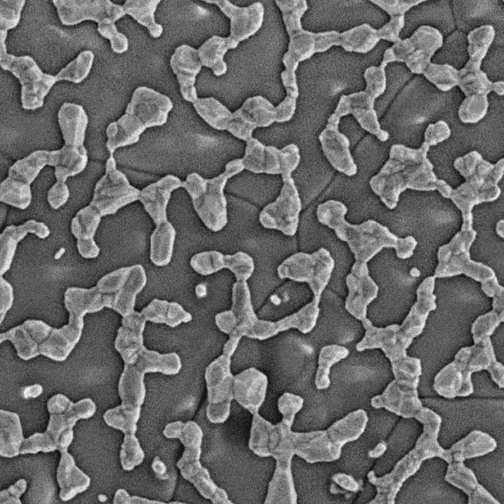

In [3]:
sofc_tensor, sofc_img = tr.load_image("data/sofc.jpg", transform_2)
sofc_tensor = sofc_tensor.to(torch.float16)
sofc_tensor = sofc_tensor.to("cuda")
sofc_img

In [4]:
high_res_features, low_res_features = net.forward(sofc_tensor)

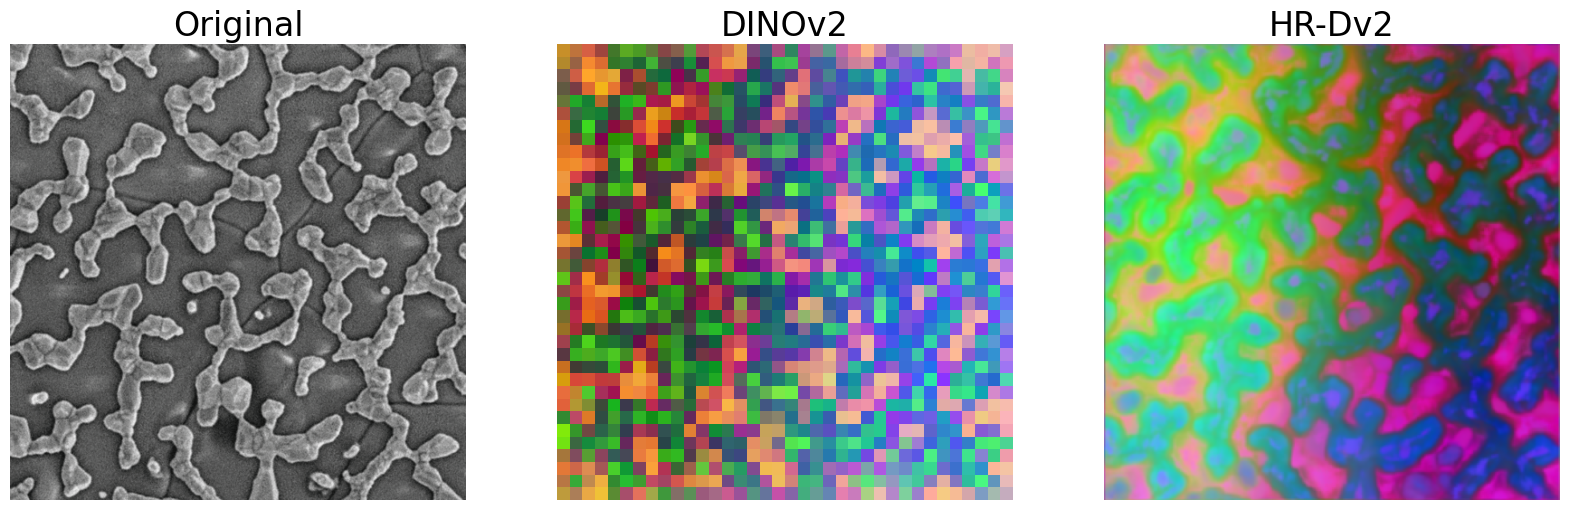

In [5]:
feat_arr_hr, feat_arr_lr = tr.to_numpy(high_res_features), tr.to_numpy(low_res_features)
feat_arr_hr = feat_arr_hr.reshape((net.feat_dim, H * W))
feat_arr_hr = feat_arr_hr.T

fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 12)

axs[0].imshow(sofc_img)
axs[0].set_title("Original", fontsize=24)
axs[0].set_axis_off()

titles = ["DINOv2", "HR-Dv2"]

pcas: List[np.ndarray] = []
features = [feat_arr_lr, feat_arr_hr]
i = 0
for arr, shapes in zip(features, [(H // 14, W // 14, 3), (H, W, 3)]): # was (H, W, 3)
    feat_pca = do_single_pca(arr)
    rescale_feat_pca = rescale_pca(feat_pca)
    pcas.append(feat_pca)

    ax = axs[i  + 1]
    ax.imshow(rescale_feat_pca.reshape(shapes)[:, :, :])
    ax.set_title(titles[i], fontsize=24)
    ax.set_axis_off()
    i += 1 

In [6]:
net.set_transforms([], [])
ve_feats, _ = net.forward(sofc_tensor)

flip_fwd, flip_inv = tr.get_flip_transforms()
print(flip_fwd, flip_inv)
net.set_transforms(flip_fwd, flip_inv)
gradient_fixed_feats, _ = net.forward(sofc_tensor)

[functools.partial(<function iden at 0x7fac441d69e0>), functools.partial(<function get_flip_transforms.<locals>.flip_arg_rev at 0x7fac0c8fbe20>, (-1,)), functools.partial(<function iden at 0x7fac441d69e0>), functools.partial(<function get_flip_transforms.<locals>.flip_arg_rev at 0x7fac0c8fbe20>, (-2,))] [functools.partial(<function iden at 0x7fac441d69e0>), functools.partial(<function get_flip_transforms.<locals>.flip_arg_rev at 0x7fac0c8fbe20>, (-1,)), functools.partial(<function iden at 0x7fac441d69e0>), functools.partial(<function get_flip_transforms.<locals>.flip_arg_rev at 0x7fac0c8fbe20>, (-2,))]


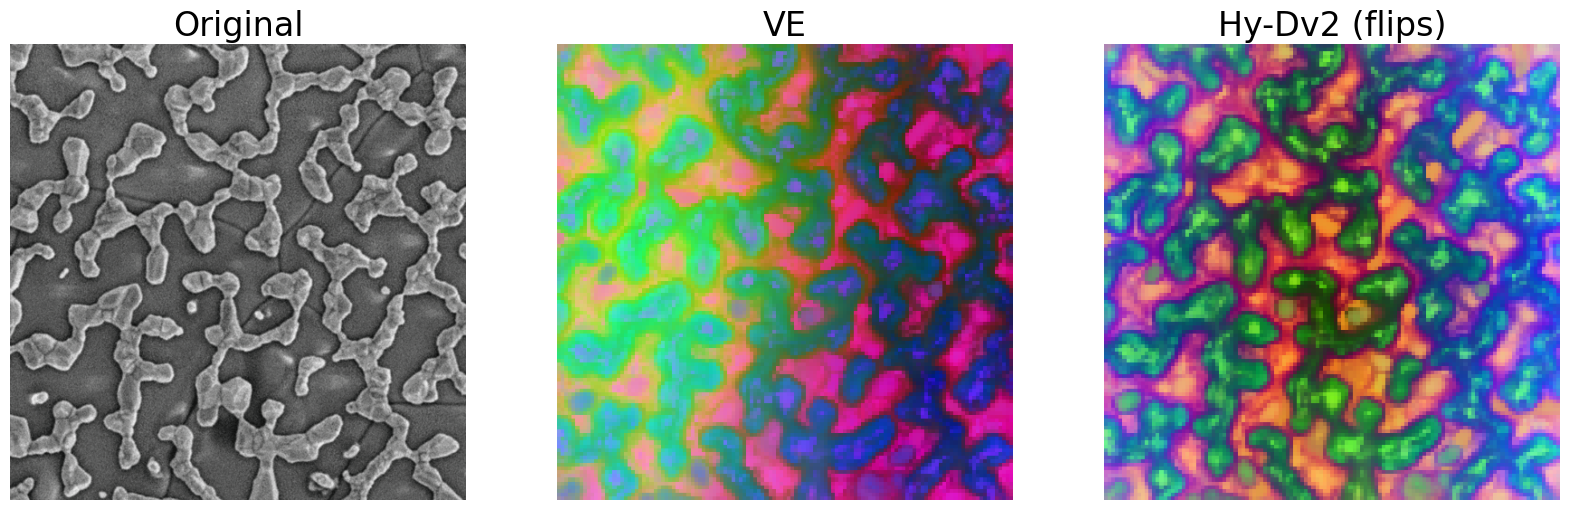

In [7]:
feat_arr_fixed, feat_arr_ve = tr.to_numpy(gradient_fixed_feats), tr.to_numpy(ve_feats)
feat_arr_ve = feat_arr_ve.reshape((net.feat_dim, H * W))
feat_arr_ve = feat_arr_ve.T
feat_arr_fixed = feat_arr_fixed.reshape((net.feat_dim, H * W))
feat_arr_fixed = feat_arr_fixed.T

fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 12)

axs[0].imshow(sofc_img)
axs[0].set_title("Original", fontsize=24)
axs[0].set_axis_off()

titles = ["VE", "Hy-Dv2 (flips)"]

pcas: List[np.ndarray] = []
features = [feat_arr_ve, feat_arr_fixed]
i = 0
for arr, shapes in zip(features, [(H, W, 3), (H, W, 3)]): # was (H, W, 3)
    feat_pca = do_single_pca(arr)
    rescale_feat_pca = rescale_pca(feat_pca)
    pcas.append(feat_pca)

    ax = axs[i  + 1]
    ax.imshow(rescale_feat_pca.reshape(shapes)[:, :, :])
    ax.set_title(titles[i], fontsize=24)
    ax.set_axis_off()
    i += 1 

In [8]:
rot_fwd, rot_inv = tr.get_rotation_transforms()
fwd_shift, inv_shift = tr.get_shift_transforms(shifts, 'Moore')
fwd_1, inv_1 = tr.combine_transforms(rot_fwd, flip_fwd, rot_inv, flip_inv)
fwd_2, inv_2 = tr.combine_transforms(fwd_shift, fwd_1, inv_shift, inv_1)
print(len(fwd_2))
net.set_transforms(rot_fwd, rot_inv)
rot_fixed_feats, _ = net.forward_sequential(sofc_tensor)

384


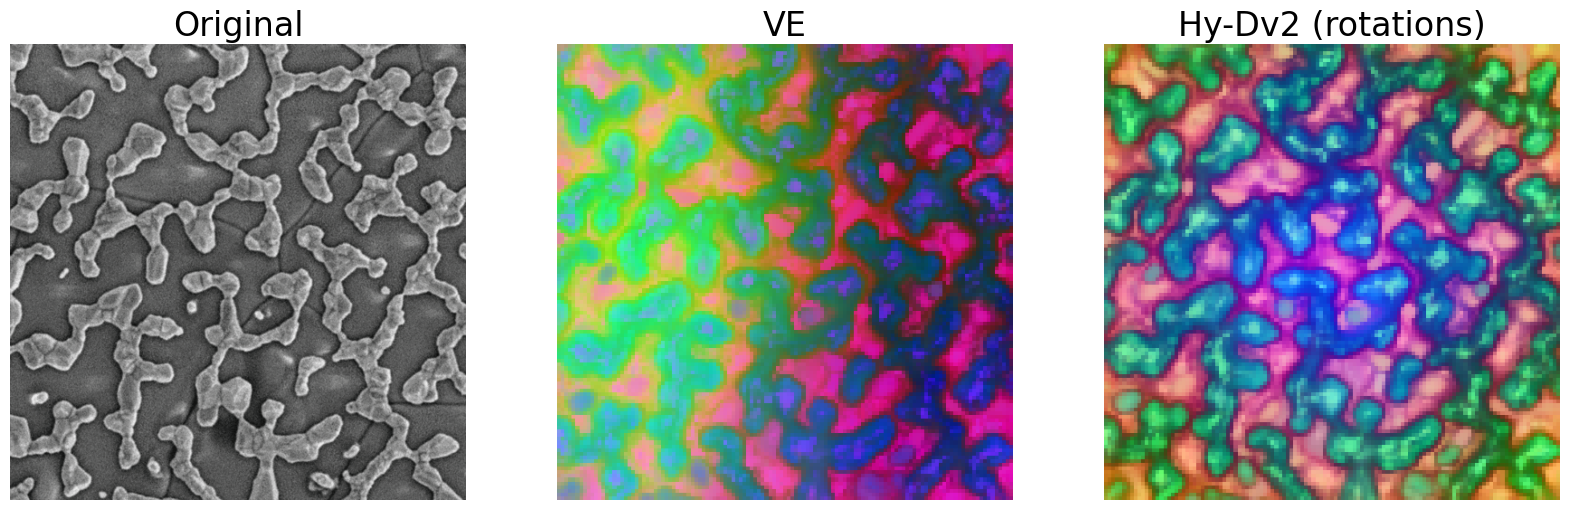

In [9]:
feat_arr_fixed, feat_arr_ve = tr.to_numpy(rot_fixed_feats), tr.to_numpy(ve_feats)
feat_arr_ve = feat_arr_ve.reshape((net.feat_dim, H * W))
feat_arr_ve = feat_arr_ve.T
feat_arr_fixed = feat_arr_fixed.reshape((net.feat_dim, H * W))
feat_arr_fixed = feat_arr_fixed.T

fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 12)

axs[0].imshow(sofc_img)
axs[0].set_title("Original", fontsize=24)
axs[0].set_axis_off()

titles = ["VE", "Hy-Dv2 (rotations)"]

pcas: List[np.ndarray] = []
features = [feat_arr_ve, feat_arr_fixed]
i = 0
for arr, shapes in zip(features, [(H, W, 3), (H, W, 3)]): # was (H, W, 3)
    feat_pca = do_single_pca(arr)
    rescale_feat_pca = rescale_pca(feat_pca)
    pcas.append(feat_pca)

    ax = axs[i  + 1]
    ax.imshow(rescale_feat_pca.reshape(shapes)[:, :, :])
    ax.set_title(titles[i], fontsize=24)
    ax.set_axis_off()
    i += 1 

We still get positional effects, even with augementations. For flip augmentations, we get effects at the edges and for rotation augmentations we get a focus on the centre.